# New Project

***
The goal of this project is to find a way to categorize text posts taken from the Smith Confessional and train an algorithm to do it in the future
 

## Import block

In [3]:
# Import block
%matplotlib inline 

from proj3 import * 


from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer #!
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial import distance
import pytest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import random
from scipy.spatial import distance
from sklearn.cluster import KMeans

## Data Pre-processing
***
I use the `Confesh_posts_master.csv` file to get the text data I will use for my analysis. I then convert the text into unicode strings, which is a standardized kind of encoding, so it can be processed by a function called `TfidfVectorizer`. 

The `TfidfVectorizer` function pre processes my data so that I can make sure I don't get any weird errors from unrecognized characters (like emojis) and that only important words are counted. In the parameters of this function, I set 'TfidfVectorizer' to remove white space and punctuation from the posts, remove English stopwords which are common but do not add any information to my analysis (like "the"), filter out words that have very few occurances (appear in less than .01% of the posts), and remove special characters that could confuse my later functions. 

Once the text data is fitered, `TfidfVectorizer` tokenizes (assigns numerical identifiers to) the words that made it through the filtering process  and counts how many times they occur. I used `TfidfVectorizer` in particular becayse it normalized and weights tokens that appear in most documents, so spam or filler words like "lol" will not be counted too much. 

I then build an analyzer so I could see what word tokens made it through the filter and adjust my filter parameters if necessary. 

In [4]:
# Import data
students = pd.read_csv("Confesh_posts_master.csv")

In [5]:
# Check data
print(students.shape)
students.head()

(4726, 3)


,Unnamed: 0,Post,Comments
0,5744,Real confessional thread: post something you'r...,327
1,495,worst prof you've had at Smith?,176
2,2271,anyone else still sleep with stuffed animals? ...,97
3,2272,kathys speech wtf,95
4,2122,finding out some smithies just don’t vote is s...,87


In [6]:
# figured out from here https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document
# convert posts into unicode so TfidfVectorizer can actually process them
text = students['Post'].values.astype('U')  
text

array(["Real confessional thread: post something you're scared to say out loud.",
       "worst prof you've had at Smith?",
       'anyone else still sleep with stuffed animals? and what kind of animal :)',
       ..., 'whats ur enneagram tritype and mbti type? ',
       'is anyone selling pre-rolls?? desperately in need if a joint rn (throwaway: smiththrowaway3456@gmail.com)',
       'anyone looking for tickets to New York? I have tickets leaving the 11/23 for 11:15am from Springfield Station (Frank B Murray Street) hit me up: throwaway220922@gmail.com'],
      dtype='<U1000')

In [9]:
# initializes TfidfVectorizer, which will make a dictionary of vectorized words
vect = TfidfVectorizer(strip_accents = "unicode", stop_words = {'english'}, min_df=0.0001)  

# fits (performs value calculation) and transforms (applies calculation to every data point) 
train_vect = vect.fit_transform(text)

In [26]:
# check data, 4726 sampled and 8791 features
np.shape(train_vect)

(4726, 8791)

In [27]:
# builds analyzer, which tokenizes the words in the numpy matrix that are > 2 char
analyzer = vect.build_analyzer()

# prints the words in the analyzer, so I can check that none of it looks crazy
vect.get_feature_names_out()

array(['00', '05', '0l', ..., 'وانت', '初音ミク', '我是一个傻瓜'], dtype=object)

## Unsupervised ML: Finding my k value
***

Now that I have my text data in a numerical form (the counts), I want to use the elbow method to find the best number of clusters for it. The elbow method involves creating k-means clusters with a variety of centers (which I pass in as a list), computing the sum of squares for each iteration, and graphing them. 

From the graph, I identify the "elbow", or the point at which the slope of the line starts decreasing in a linear fashion. This is the best number of clusters for my data. Based on elbowology, my k should be 9, which means that I will ask my k-means model to cluster my text data into 9 groups. 

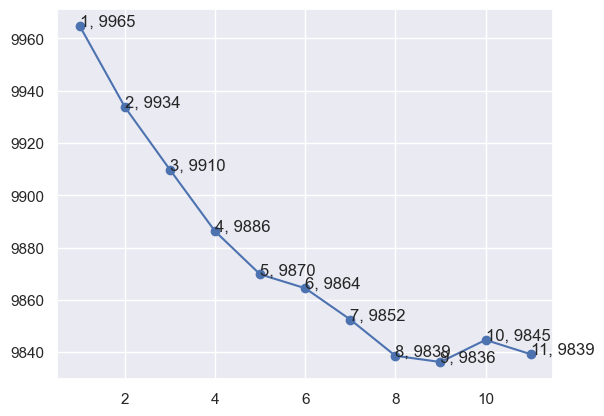

[9964.68540183828,
 9933.744852578931,
 9909.758548418165,
 9886.230353794635,
 9869.758236412974,
 9864.45568750497,
 9852.474626395082,
 9838.608345514553,
 9836.240973599743,
 9844.683662472406,
 9839.234323052442]

In [28]:
# I run my tokenized posts in k-means models with 1, 2, 3, ..., 11, and 12 centers.
# based on this graph, the hinge is at 9 centers

lst = looping_kmeans(train_vect.A, list(range(1,12)))
lst

## Unsupervised ML: Running k-Means 
***

Now that I know how many clusters I want, I can use k-Means to label my posts based on which of the 9 centroids (middle points of the clusters, generated by the computer) they are most similar to. 

I save the posts with their corresponding labels as their own file `labeled_masters_9.csv` to make it easy to look at them later

In [29]:
fit1 = run_kmeans_sklearn(train_vect.A, 2) 

In [30]:
# checks for myself that the correct labels were created and taking a peak and the cluster centers 

print("Labels\n", fit1.labels_)
print("Labels\n", np.shape(fit1.labels_))
print("Labels\n", np.unique(fit1.labels_))

print("\n Cluster Centers \n",fit1.cluster_centers_)
print("\n Cluster Centers \n",np.shape(fit1.cluster_centers_))

Labels
 [1 0 0 ... 0 0 0]
Labels
 (4726,)
Labels
 [0 1]

 Cluster Centers 
 [[ 1.48403041e-04  1.35525272e-19  1.38490816e-04 ...  1.30181215e-04
   3.18877551e-04  2.34561414e-04]
 [ 4.60386131e-04  1.25117460e-04  8.13151629e-20 ... -4.06575815e-20
   2.16840434e-19 -1.89735380e-19]]

 Cluster Centers 
 (2, 8791)


In [106]:
# Saving my data with labels as its own csv so I can look at it later

students["Labels (9)"] = fit1.labels_
pd.DataFrame(students, columns = ['Post','Comments','Labels (9)', 'Hand Labels']).to_csv('labeled_masters_9.csv', mode='w', index=False, header=True)


## Pull 10 Samples out of each cluster to understand the trends
***
I then randomly sample 10 posts from all the posts with each label in order to try and understand what trends k-Means is clustering based on. 

I label each sample with how I would describe the category. They are roughly:
1. Seems to be random comments and complaints about Smith as a place and other miscellaneous personal opinons
2. Seems to be posts about specific people on Smith campus
3. Seems to be about "people" in general at smith and giving advice/offering personal opnions on what people should and shoudln't do
4. Seems to be asking questions about community organization here creating groups, pattern is "does"
5. People sharing vents and asking for help with interpersonal conflict, also asking about community norms
6. The pattern seems to be the presence of "anyone", but the questions tend to be general asks about functional things (sales, classes, missing items)
7. The pattern seems to be the presence of "what", byt they seem to be undirected questions meant to create engagment rather than reach a specific point
8. This seems to be complaining, with an emphasis on relationships, hygeine, and stress and personal situations
9. Tthis seems to be vents and aimed at getting specific advice or help for the poster, or general polls

In [35]:
# Seems to be random comments and complaints about Smith as a place, also random drop box
take_samp(students['Post'], fit1, 0)

700            anyone know whats going  on at gardiner?? 
269                    i wanna make out w someone tonight
2982                    i wish casey bohlen was my father
402     so touched starved rn its insane, just wish i ...
4155    smith pay me back for the teletherapy im missi...
1504    vm is a bitch to student workers, why tf are y...
1042                                    ob is so annoying
4261                        whos selling edibles tonight 
2101                    can campo drive me home at night?
379     anyone else just rly sad about how no one care...
Name: Post, dtype: object


In [75]:
# seems to be about specific people 
take_samp(students['Post'], fit1, 1)

3098    who is the bitch on second floor scales that w...
1688          Shout out to the cute girl in my gov class 
2636    anyone know when the tickets for the 3rd show ...
2078    what was that noise in the quad and why did it...
1808           will cone insense set off the fire alarms?
622     jane stangl is the worlds most insufferable cu...
1532           to the provost in measure for measure- ily
3839    why doesn't smith advertise the mellon mays fe...
1995    cant away to move away from all the nasty bitc...
4678                             the fucking service here
Name: Post, dtype: object


In [76]:
# seems to be about "people" in general at smith and giving advice/personal opnions
take_samp(students['Post'], fit1,  2)

1774    ppl on here talking about what grades are good...
3722    i have no idea what the weekend dining hours a...
1146    when people are getting worked up over stupid ...
2853    don’t me become cutter hp EVER bc im gonna bul...
4712    trick or treat tracker! which houses are out o...
3511                         when are courses coming out?
2346                 i think lady and  tramp are lesbians
1327    i have a question that im too afraid to ask in...
636     the people still screaming about masking are s...
1154    tips for better head-from the girlies who wann...
Name: Post, dtype: object


In [77]:
# asking questions about community organization here creating groups, pattern is "does"
take_samp(students['Post'], fit1,  3)

2619    PLEASE why does IDP HAVE SO MUCH WORK ITS ONE ...
4076        does dawes have scrambled or fried eggs today
3001    where does the compass cafe get their food? i ...
2305    Does anyone have a spare ticket to our dear de...
1027      why does the neilson elevator talk? "Going up!'
3217    does wilson have a group chat. a house discord...
1427    so what happened to parsons house does it stil...
2881    does anyone do black friday shopping in oerson...
1470    does anyone wanna buy 2 oso oso tickets for no...
4075    does anyone need someone to watch plants over ...
Name: Post, dtype: object


In [78]:
# people sharing vents and asking for help with interpersonal conflict and asking peoplee en masse about community norms
take_samp(students['Post'], fit1,  4)

4039    i lost my fast charging iphone charger and im ...
1991    anyone else feel like theyre gonna combust eve...
138     first romantic entanglement with a neurotypica...
140     antisemitism is bad and the school and our com...
58      i need some advice on a roommate conflict. so ...
547     nothing screams ‘touch grass’ more than foreig...
3872    i was so worried about getting played that i t...
1222    when u finish a particularly excellent and imm...
148     whoever stole my yoga mat from cushem dining h...
2626    please someone has a crush on me. im feeling s...
Name: Post, dtype: object


In [79]:
# The pattern seems to be the presence of "anyone", but the questions tend to be general asks about functional things (sales, classes, missing items)
take_samp(students['Post'], fit1,  5)

841                           anyone willing to sell alc?
3509    anyone know where to meet abarca for office ho...
2714              has anyone seen missinf black car keys😭
1179    anyone wanna buy burgundy canvas docs for $30?...
2641    has anyone had pia furkan for a soc class if s...
4550    could anyone please do a NETA run this Wednesd...
2061    Has anyone found an apple pencil (gen1) at nei...
4452      anyone selling weed? @smiththrownaway@gmail.com
2512         anyone here going to anime nyc this weekend?
3324                   is anyone going to cognitive psych
Name: Post, dtype: object


In [80]:
# The pattern seems to be the presence of "what", byt they seem to be undirected questions meant to create engagment rather than reach a specific point
take_samp(students['Post'], fit1,  6)

7                           whats ur ultimate sex fantasy
17              whats your best friend's major and yours?
23                                 whats ur major and gpa
47      whats happening with fetish this year? i feel ...
90                            whats ur fav number and why
                              ...                        
4629                                 whats ur fav snack? 
4630                                 whats the cheering? 
4643    whats ur fav dessert? i like the ispahan from ...
4676                           whats going on in gardiner
4723           whats ur enneagram tritype and mbti type? 
Name: Post, Length: 80, dtype: object


In [86]:
# this seems to be complaining, with an emphasis on relationships, hygeine, and stress and a general audience
take_samp(students['Post'], fit1,  7)

689     how do i tell if someone is trying to fuck me ...
3099    i might be depressed, stressed, and underdress...
2177      lol how do u know if someone restricted u on fb
924     on GOD can people please wear deodorant if the...
2953    what do u do/say if u found a guy cute in a pa...
692                               do u recommend soc 101 
1992    what do you think your most listened to song o...
1797    as a politician your career rests on how much ...
1612     i like them but they dont like me.. wtf do i do 
2583    how does bedding/ having pillows work if you s...
Name: Post, dtype: object


In [88]:
# this seems to be vents and aimed at getting specific advice or help for the poster, or general polls
take_samp(students['Post'], fit1,  8)

258     i think we should write a petition to fire bio...
3821    I need a concert buddy who wants to go to almo...
1190    if youre eating in a dining hall, you can look...
2576    wowzer bowzer passed away for real yesterday. ...
75      stupid bitches make me wanna kms. on god ya’ll...
3891    anyone know if theres a certain limit to how m...
2803    i dont think im fit to live in (modern day) so...
1079    i need to hold a cat immediately who is willin...
1353    best of luck to yall, but you will NEVER see m...
340     how do people usually get to the amtrak statio...
Name: Post, dtype: object


## Supervised Learning: kNN clustering
***
I then use the category explanations to manually check and adjust the labels of 50 points based on my interpretation of the content in the `Hand Labels` category.
I then used the k-means labeled data to figure out parameters for my kNN model, by training my kNN on `Labels (06)` and checking prediction accuracy scores (which were overally not great). The best neighbor number seemed to be 3. 
I then created a kNN model trained on the `Hand Labels` category to roughly predict my own classifications. 

In [7]:
# show manually labeled points
labeled_students = pd.read_csv("labeled_masters_9.csv")
labeled_students["Hand Labels"][0:50]

0     6.0
1     8.0
2     6.0
3     0.0
4     0.0
5     0.0
6     2.0
7     6.0
8     4.0
9     0.0
10    2.0
11    6.0
12    4.0
13    6.0
14    6.0
15    0.0
16    2.0
17    6.0
18    0.0
19    0.0
20    1.0
21    8.0
22    6.0
23    6.0
24    6.0
25    4.0
26    5.0
27    0.0
28    2.0
29    8.0
30    8.0
31    3.0
32    4.0
33    1.0
34    4.0
35    0.0
36    4.0
37    2.0
38    6.0
39    4.0
40    6.0
41    8.0
42    8.0
43    4.0
44    6.0
45    8.0
46    1.0
47    0.0
48    5.0
49    0.0
Name: Hand Labels, dtype: float64

In [191]:
# take first 50 samples to train on
np.shape(train_vect.A[0:50, :]) 

(50, 8791)

In [126]:
# take labeled points
np.shape(labeled_students["Hand Labels"][0:50])

(50,)

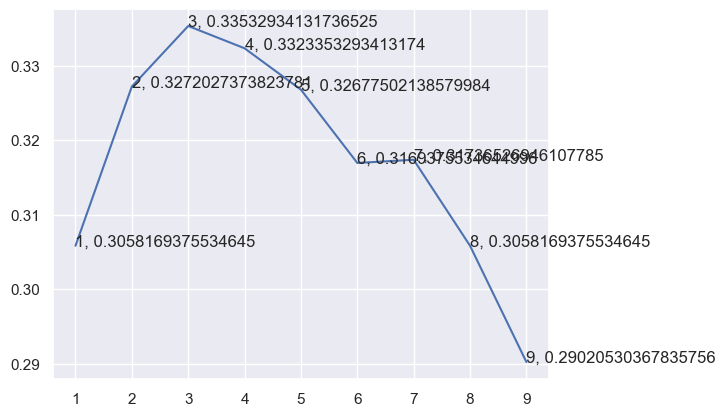

[0.3058169375534645,
 0.3272027373823781,
 0.33532934131736525,
 0.3323353293413174,
 0.32677502138579984,
 0.3169375534644996,
 0.31736526946107785,
 0.3058169375534645,
 0.29020530367835756]

In [38]:
# find the best neighbors value 
kNN_tester(train_vect.A[0:50,:], labeled_students["Labels (9)"][0:50], train_vect.A[50:,:], labeled_students["Labels (9)"][50:], list(range(1,10)))




In [10]:
# makes knn with 3 neighbors
knn3 = run_knn_sklearn(train_vect.A[0:50,:], labeled_students["Hand Labels"][0:50], 3)



In [295]:
# see how it does at predicting my train data
pred = knn3.predict(train_vect.A[0:50,:]) 

accuracy_score(labeled_students["Hand Labels"][0:50],pred)

0.62

In [261]:
# predict how I will label the rest of the hand curated points
pred = knn3.predict(train_vect.A[50:,:])
pred

array([2., 2., 4., ..., 6., 1., 0.])

In [264]:
# compare my hand curated labels and the k-means labels
print(accuracy_score(labeled_students["Labels (9)"][0:50],labeled_students["Hand Labels"][0:50]))

# compare my (predicted) hand curated labels and the k-means labels
print(accuracy_score(labeled_students["Labels (9)"][50:],pred))

0.5
0.29426860564585117


In [ ]:
labeled_students["Hand Labels"] = labeled_students["Hand Labels"][0:50].append(pred)

## Final Thoughts
***
The accuracy of my kNN left something to be desired, but given how subjective the data was, how large the tokenized matrix was, and how small the train set was since it takes a long time to hand label, it wasn't too bad. 

This project was an interesting way to compare the roles of supervised and unsupervised models and implement a variety of machine learning algorithms in python and assess their efficacy

In [ ]:

def test_run_knn_sklearn_type():
    assert isinstance(proj3.run_knn_sklearn(justtwo_np[0:50],
          students["Hand Labels"], 2), KNeighborsClassifier)

def test_take_samp_size():
    expected = 10
    fit1 = proj3.run_kmeans_sklearn(justtwo_np, 2)
    assert proj3.take_samp(justtwo_np["Labels (9)"],fit1, 1) == expected

def test_kNN_tester_size():
    expected = 3
    assert len(proj3.kNN_tester(justtwo_np["Comments"][0:50], justtwo_np["Labels (9)"][:, 0:50], justtwo_np["Comments"][:, 0:50], justtwo_np["Labels (9)"][0:50], [1, 2, 3])) == expected

def test_looping_kmeans_size():
    expected = 1
    assert len(proj3.looping_kmeans(justtwo_np,
        list(range(1,2)))) == expected
 



In [12]:
students = pd.read_csv("labeled_masters_9.csv")
justtwo_np = students[["Labels (9)","Comments"]].to_numpy()

In [14]:
h =run_knn_sklearn(justtwo_np[0:50], students["Hand Labels"][0:50], 2)

In [31]:
fit2 = run_kmeans_sklearn(justtwo_np, 2)
type(take_samp(students["Labels (9)"],fit2, 1))

92     0
71     0
179    0
172    0
164    4
87     0
109    1
131    4
101    0
0      8
Name: Labels (9), dtype: int64


NoneType

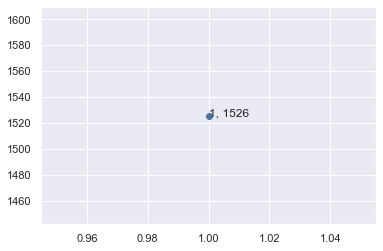

1

In [27]:
len(looping_kmeans(justtwo_np,
        list(range(1,2))))